In [1]:
import pandas as pd
import numpy as np
from plotnine import *  
import xgboost as xgb 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
)
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # progress bar
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

rider_data = pd.read_csv('/Users/connortoomey/Desktop/Mod2 Machine Learning/TDF_Riders_History.csv')
stage_data = pd.read_csv('/Users/connortoomey/Desktop/Mod2 Machine Learning/TDF_Stages_History.csv')


In [2]:
rider_data.describe(include='all')



,Rank,Rider,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,ResultType,TotalSeconds,GapSeconds
count,10179.000000,10179,10179.000000,10179,10179,10179,276,64,10179.000000,10179.000000,10179.000000,10105,1.017900e+04,10179.000000
unique,NaN,3601,NaN,694,9742,7518,39,6,NaN,NaN,NaN,2,NaN,NaN
top,NaN,SYLVAIN CHAVANEL,NaN,FRANCE,00h 00' 00'',-,04',00' 20'',NaN,NaN,NaN,time,NaN,NaN
freq,NaN,16,NaN,193,74,368,50,29,NaN,NaN,NaN,9908,NaN,NaN
mean,58.704195,NaN,90.624521,NaN,NaN,NaN,NaN,NaN,1984.123686,3927.078200,22.138324,NaN,4.106495e+05,9629.019747
std,41.411740,NaN,60.881006,NaN,NaN,NaN,NaN,NaN,30.631933,570.258934,2.937939,NaN,1.848183e+05,13377.273998
min,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1903.000000,2428.000000,6.000000,NaN,0.000000e+00,0.000000
25%,24.000000,NaN,37.000000,NaN,NaN,NaN,NaN,NaN,1965.000000,3492.000000,21.000000,NaN,3.198410e+05,4017.000000
50%,51.000000,NaN,84.000000,NaN,NaN,NaN,NaN,NaN,1990.000000,3765.000000,21.000000,NaN,3.478370e+05,7618.000000
75%,88.000000,NaN,135.000000,NaN,NaN,NaN,NaN,NaN,2009.000000,4231.000000,24.000000,NaN,4.275900e+05,11118.500000


In [3]:
rider_data.head()

,Rank,Rider,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,ResultType,TotalSeconds,GapSeconds
0,1,TADEJ POGACAR,1,UAE TEAM EMIRATES XRG,76h 00' 32'',-,52',NaN,2025,3323,21,time,273632,0
1,2,JONAS VINGEGAARD HANSEN,11,TEAM VISMA | LEASE A BIKE,76h 04' 56'',+ 00h 04' 24'',34',NaN,2025,3323,21,time,273896,264
2,3,FLORIAN LIPOWITZ,72,RED BULL - BORA - HANSGROHE,76h 11' 32'',+ 00h 11' 00'',04',NaN,2025,3323,21,time,274292,660
3,4,EDGAR OSCAR ONLEY,191,TEAM PICNIC POSTNL,76h 12' 44'',+ 00h 12' 12'',04',NaN,2025,3323,21,time,274364,732
4,5,FELIX GALL,151,DECATHLON AG2R LA MONDIALE TEAM,76h 17' 44'',+ 00h 17' 12'',NaN,NaN,2025,3323,21,time,274664,1032


In [4]:
stage_data.head()

,Year,TotalTDFDistance,Stages,Start,End,Winner of stage,Yellow Jersey,Green jersey,Polka-dot jersey,White jersey,Leader
0,2025,3323,1.0,Lille Métropole,Lille Métropole,Jasper Philipsen (Alpecin-Deceuninck),Jasper Philipsen,Anthony Turgis,Benjamin Thomas,Biniam Girmay,NaN
1,2025,3323,2.0,Lauwin-Planque,Boulogne-sur-Mer,Mathieu Van Der Poel (Alpecin-Deceuninck),Mathieu Van Der Poel,Jasper Philipsen,Tadej Pogacar,Kévin Vauquelin,NaN
2,2025,3323,3.0,Valenciennes,Dunkerque,Tim Merlier (Soudal Quick-Step),Mathieu Van Der Poel,Jonathan Milan,Tim Wellens,Kévin Vauquelin,NaN
3,2025,3323,4.0,Amiens Métropole,Rouen,Tadej Pogacar (Uae Team Emirates Xrg),Mathieu Van Der Poel,Jonathan Milan,Tadej Pogacar,Kévin Vauquelin,NaN
4,2025,3323,5.0,Caen,Caen,Remco Evenepoel (Soudal Quick-Step),Tadej Pogacar,Jonathan Milan,Jonas Vingegaard Hansen,Remco Evenepoel,NaN


In [5]:
stage_data.columns.to_list()


['Year',
 'TotalTDFDistance',
 'Stages',
 'Start',
 'End',
 'Winner of stage',
 'Yellow Jersey',
 'Green jersey',
 'Polka-dot jersey',
 'White jersey',
 'Leader']

In [6]:
rider_data.columns.to_list()

['Rank',
 'Rider',
 'Rider No.',
 'Team',
 'Times',
 'Gap',
 'B',
 'P',
 'Year',
 'Distance (km)',
 'Number of stages',
 'ResultType',
 'TotalSeconds',
 'GapSeconds']

In [7]:
rider_data["Won_Tour"] = (rider_data["Rank"] == 1).astype(int)

In [8]:
import re

def convert_hms_to_decimal_hours(hms_string):
    # Extract numbers using a regular expression
    match = re.match(r"(\d+)h\s*(\d+)'\s*(\d+)''", hms_string)
    if not match:
        raise ValueError("Invalid format for HMS string")

    hours = int(match.group(1))
    minutes = int(match.group(2))
    seconds = int(match.group(3))

    # Convert to decimal hours
    decimal_hours = hours + (minutes / 60) + (seconds / 3600)
    return decimal_hours

hms_string = "76h 00' 32''"
numeric_value = convert_hms_to_decimal_hours(hms_string)
print(numeric_value)

76.00888888888889


In [9]:

rider_data["Total_Time_Hours"] = rider_data["Times"].apply(convert_hms_to_decimal_hours)



In [10]:
rider_data[['Times', 'Total_Time_Hours']].head()


,Times,Total_Time_Hours
0,76h 00' 32'',76.008889
1,76h 04' 56'',76.082222
2,76h 11' 32'',76.192222
3,76h 12' 44'',76.212222
4,76h 17' 44'',76.295556


In [11]:
rider_data.head()



,Rank,Rider,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,ResultType,TotalSeconds,GapSeconds,Won_Tour,Total_Time_Hours
0,1,TADEJ POGACAR,1,UAE TEAM EMIRATES XRG,76h 00' 32'',-,52',NaN,2025,3323,21,time,273632,0,1,76.008889
1,2,JONAS VINGEGAARD HANSEN,11,TEAM VISMA | LEASE A BIKE,76h 04' 56'',+ 00h 04' 24'',34',NaN,2025,3323,21,time,273896,264,0,76.082222
2,3,FLORIAN LIPOWITZ,72,RED BULL - BORA - HANSGROHE,76h 11' 32'',+ 00h 11' 00'',04',NaN,2025,3323,21,time,274292,660,0,76.192222
3,4,EDGAR OSCAR ONLEY,191,TEAM PICNIC POSTNL,76h 12' 44'',+ 00h 12' 12'',04',NaN,2025,3323,21,time,274364,732,0,76.212222
4,5,FELIX GALL,151,DECATHLON AG2R LA MONDIALE TEAM,76h 17' 44'',+ 00h 17' 12'',NaN,NaN,2025,3323,21,time,274664,1032,0,76.295556


In [12]:

# Sort data by Rider and Year so past results come first
df = rider_data.sort_values(["Rider", "Year"])

# 1. Compute each rider's deviation from the winner
# (It's already GapSeconds in your data, but this line ensures correctness)
df["Deviation"] = df["GapSeconds"]

# 2. Compute rolling average deviation from all *previous* races
df["AvgPrevDeviation"] = (
    df.groupby("Rider")["Deviation"]
      .apply(lambda s: s.shift().expanding().mean())
      .reset_index(level=0, drop=True)   # <-- IMPORTANT FIX
)

df

#drop rider
#use team to get another predictor variable
#use team for get dummies

,Rank,Rider,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,ResultType,TotalSeconds,GapSeconds,Won_Tour,Total_Time_Hours,Deviation,AvgPrevDeviation
6766,87,AAD VAN DEN HOEK,58,TI-RALEIGH-CAMPAGNOLO,119h 35' 17'',+ 03h 12' 54'',NaN,NaN,1976,4017,27,time,430517,11574,0,119.588056,11574,NaN
6605,57,AAD VAN DEN HOEK,18,TI-RALEIGH-McGREGOR,110h 11' 13'',+ 01h 53' 13'',NaN,NaN,1978,3908,25,time,396673,6793,0,110.186944,6793,11574.0
6369,115,AAD VAN DEN HOEK,8,TI-RALEIGH-CREDA,94h 45' 43'',+ 03h 11' 29'',NaN,NaN,1981,3753,25,time,341143,11489,0,94.761944,11489,9183.5
4148,88,AART VIERHOUTEN,58,RABOBANK,95h 24' 52'',+ 02h 35' 06'',NaN,NaN,1998,3875,22,time,343492,9306,0,95.414444,9306,NaN
9094,42,ABDEL-KADER ABBES,101,TOURISTES ROUTIERS,147h 31' 05'',+ 04h 43' 33'',NaN,NaN,1936,4442,27,time,531065,17013,0,147.518056,17013,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,103,ZDENEK STYBAR,116,ETIXX-QUICK STEP,88h 16' 27'',+ 03h 30' 13'',NaN,NaN,2015,3354,21,time,317787,12613,0,88.274167,12613,NaN
1274,102,ZDENEK STYBAR,107,QUICK - STEP FLOORS,89h 33' 07'',+ 03h 12' 12'',NaN,NaN,2017,3540,21,time,322387,11532,0,89.551944,11532,12613.0
4657,3,ZENON JASKULA,84,GB-MG-MAGLIFICIO,96h 02' 57'',+ 00h 05' 48'',NaN,NaN,1993,3714,21,time,345777,348,0,96.049167,348,NaN
4470,46,ZENON JASKULA,31,AKI-GIPIEMME,94h 38' 45'',+ 01h 53' 46'',NaN,NaN,1995,3635,21,time,340725,6826,0,94.645833,6826,348.0


In [13]:
best_features = [
    "Rank",
    "Year",
    "Distance (km)",
    "Number of stages",
    "GapSeconds",
    "Total_Time_Hours",
    "Deviation",
    "AvgPrevDeviation"
]




In [14]:
!pip -q install statsmodels patsy stargazer
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from plotnine import *
import math
from stargazer.stargazer import Stargazer
from IPython.display import HTML, display

In [15]:
df.describe(include='all')
df['AvgPrevDeviation'].describe()

count      6578.000000
mean       8276.415230
std       10205.016393
min           0.000000
25%        3835.750000
50%        6853.666667
75%       10047.285714
max      175235.000000
Name: AvgPrevDeviation, dtype: float64

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_density : Removed 3601 rows containing non-finite values.


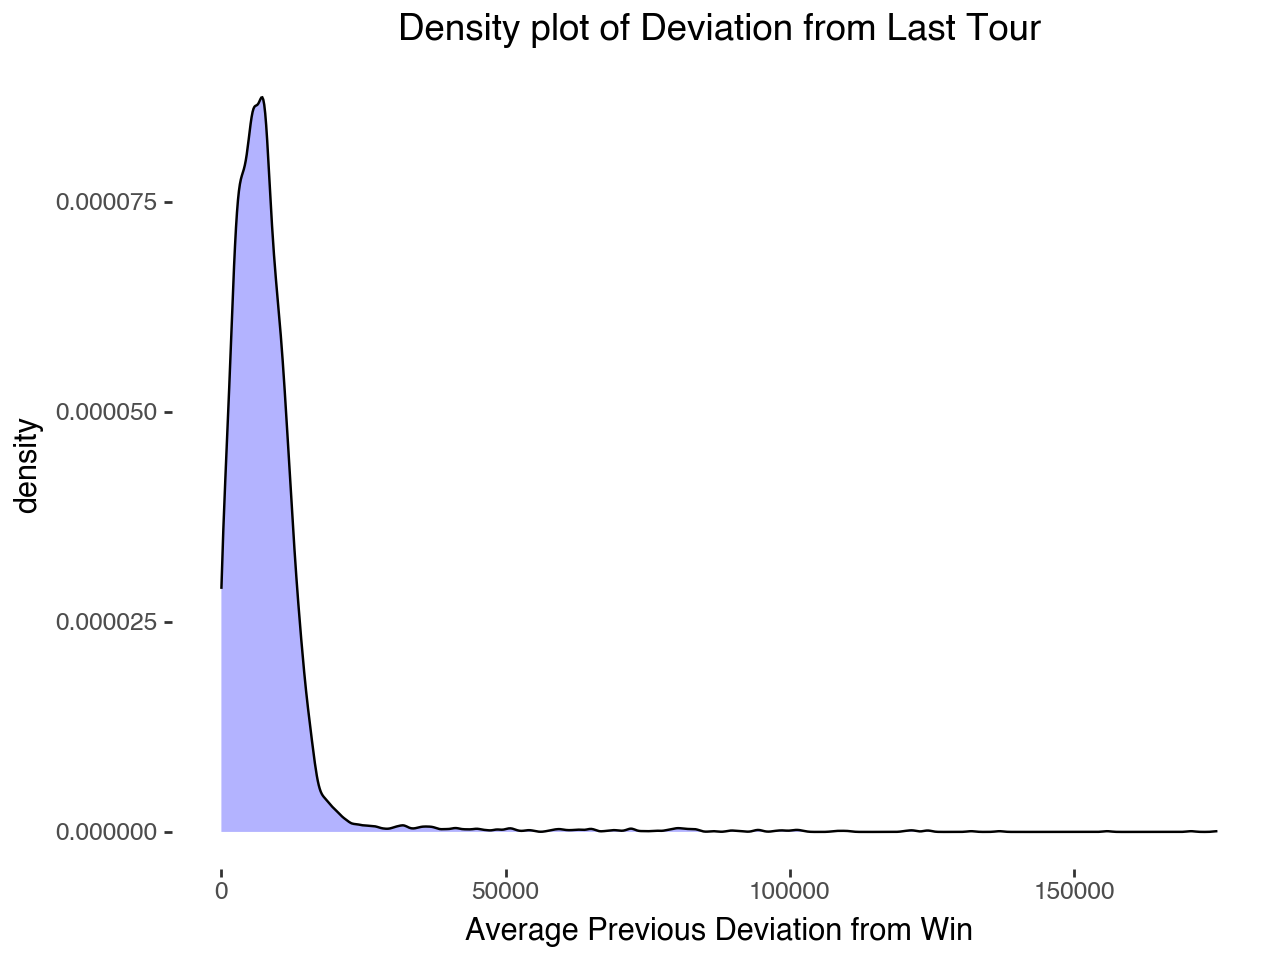

In [16]:
g_1 = ( # Start Plot
    ggplot(df, # Set dataset
           aes(x="AvgPrevDeviation")) 
    + geom_density(fill="blue", alpha=0.3)  # Use geom_density to get density plot
    + theme_bw() # Set theme for plot
    + theme(
        panel_grid_major=element_blank(), # Turn of the background grid
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
    )
    + labs(x="Average Previous Deviation from Win", title="Density plot of Deviation from Last Tour") # Set plot labels
)

# Display plot
g_1

In [17]:
fit_1 = smf.ols(formula='Deviation~ AvgPrevDeviation', data=df).fit()

In [18]:
fit_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Deviation   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     3078.
Date:                Fri, 05 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:11:08   Log-Likelihood:                -68799.
No. Observations:                6578   AIC:                         1.376e+05
Df Residuals:                    6576   BIC:                         1.376e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3745.0922    133.906     27.968      0.000    3482.593    4007.592
AvgPrevDeviation     0.5654      0.010     55.481      0.000       0.545       0.585
==============================================================================
Omnibus:                     9114.383   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3241190.261
Skew:                           7.956   Prob(JB):                         0.00
Kurtosis:                     110.575   Cond. No.                     1.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
stargazer = Stargazer([fit_1])               # Set up Stargazer
stargazer.title("Linear Regression Results") # Set title
stargazer.custom_columns(["Model (1)"], [1]) # Set column label


# Render to HTML
display(HTML(stargazer.render_html()))

In [20]:
df2 = rider_data.sort_values(["Team", "Year"])

# 1. Compute each Team's deviation from the winner
# (It's already GapSeconds in your data, but this line ensures correctness)
df2["Deviation"] = df2["GapSeconds"]

df2["AvgPrevDeviation_team"] = (
    df.groupby("Team")["Deviation"]
      .apply(lambda s: s.shift().expanding().mean())
      .reset_index(level=0, drop=True)   
)

df2

,Rank,Rider,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,ResultType,TotalSeconds,GapSeconds,Won_Tour,Total_Time_Hours,Deviation,AvgPrevDeviation_team
5390,24,JAANUSZ KUUM,204,A.D.R. - I.O.C.,85h 06' 46'',+ 00h 38' 53'',NaN,NaN,1988,3286,23,time,306406,2333,0,85.112778,2333,9219.80
5467,102,FRANK DE WOLF,202,A.D.R. - I.O.C.,86h 23' 49'',+ 01h 55' 56'',NaN,NaN,1988,3286,23,time,311029,6956,0,86.396944,6956,10271.00
5480,115,EDDY PLANCKAERT,208,A.D.R. - I.O.C.,86h 37' 27'',+ 02h 09' 34'',NaN,NaN,1988,3286,23,time,311847,7774,0,86.624167,7774,11519.50
5488,124,FRANK HOSTE,203,A.D.R. - I.O.C.,86h 46' 43'',+ 02h 18' 50'',NaN,NaN,1988,3286,23,time,312403,8330,0,86.778611,8330,9442.25
5495,131,RENÉ MARTENS,205,A.D.R. - I.O.C.,86h 52' 45'',+ 02h 24' 52'',NaN,NaN,1988,3286,23,time,312765,8692,0,86.879167,8692,8072.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,31,ANSELMO FUERTE,126,ZOR-BH,111h 47' 32'',+ 01h 12' 13'',NaN,NaN,1986,4094,24,time,402452,4333,0,111.792222,4333,1980.00
5688,40,JÉSUS RODRIGUEZ-MAGRO,128,ZOR-BH,111h 55' 28'',+ 01h 20' 09'',NaN,NaN,1986,4094,24,time,402928,4809,0,111.924444,4809,5314.80
5707,59,JUAN-CARLOS ROZAS,129,ZOR-BH,112h 17' 10'',+ 01h 41' 51'',NaN,NaN,1986,4094,24,time,404230,6111,0,112.286111,6111,5115.75
5720,72,GUIDO VAN CALSTER,130,ZOR-BH,112h 26' 01'',+ 01h 50' 42'',NaN,NaN,1986,4094,24,time,404761,6642,0,112.433611,6642,4607.00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_density : Removed 694 rows containing non-finite values.


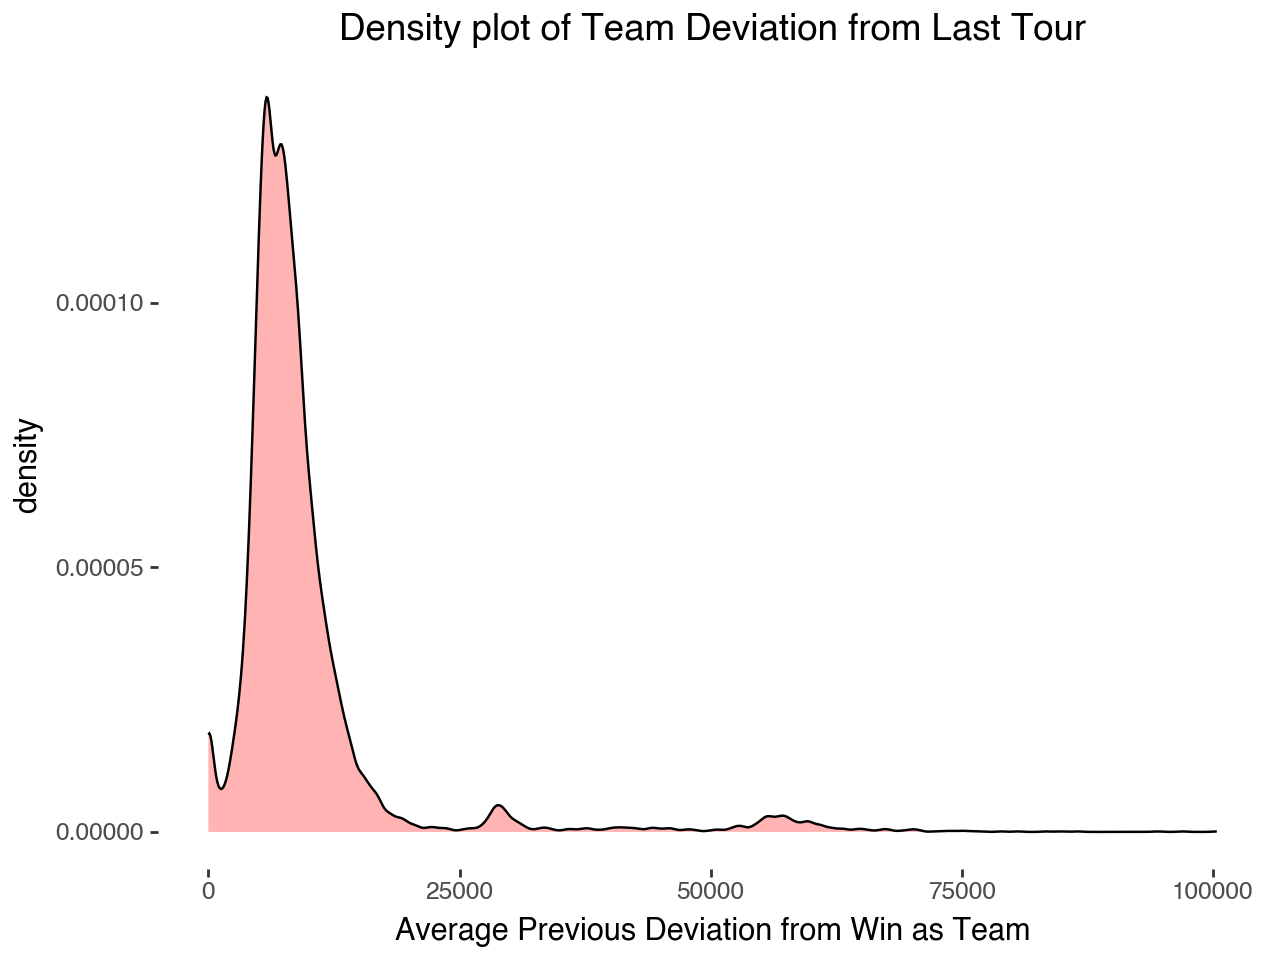

In [21]:
g_2 = ( # Start Plot
    ggplot(df2, # Set dataset
           aes(x="AvgPrevDeviation_team")) 
    + geom_density(fill="red", alpha=0.3)  # Use geom_density to get density plot
    + theme_bw() # Set theme for plot
    + theme(
        panel_grid_major=element_blank(), # Turn of the background grid
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank(),
    )
    + labs(x="Average Previous Deviation from Win as Team", title="Density plot of Team Deviation from Last Tour") # Set plot labels
)

# Display plot
g_2

In [22]:
# Create derived variables: gap to winner in last race, ranking in previous races, competition count
# These will improve model predictability by leveraging historical performance

# Sort both dataframes by Rider/Team and Year for rolling calculations
df = df.sort_values(["Rider", "Year"]).reset_index(drop=True)
df2 = df2.sort_values(["Team", "Year"]).reset_index(drop=True)

# ============= df (Rider-level) =============
# 1. Gap to winner in last race (for each rider)
df['Gap_Last_Race'] = (
    df.groupby('Rider')['GapSeconds']
    .shift(1)  # Get previous race for this rider
)

# 2. Rider's finishing rank in previous race
df['Rank_Last_Race'] = (
    df.groupby('Rider')['Rank']
    .shift(1)  # Previous rank
)

# 3. Number of times rider has competed in tour (cumulative count)
df['Competition_Count'] = (
    df.groupby('Rider').cumcount() + 1  # Count starts at 1
)

# ============= df2 (Team-level) =============
# 1. Gap to winner in last race (for each team)
df2['Gap_Last_Race_Team'] = (
    df2.groupby('Team')['GapSeconds']
    .shift(1)
)

# 2. Team's average rank in previous race
df2['Rank_Last_Race_Team'] = (
    df2.groupby('Team')['Rank']
    .shift(1)
)

# 3. Number of times team has competed (cumulative count)
df2['Competition_Count_Team'] = (
    df2.groupby('Team').cumcount() + 1
)

# Display summary statistics for the new features
print("=== New derived variables for df (Rider-level) ===")
print(df[['Rider', 'Year', 'Rank', 'Gap_Last_Race', 'Rank_Last_Race', 'Competition_Count']].head(15))
print("\nSummary statistics:")
print(df[['Gap_Last_Race', 'Rank_Last_Race', 'Competition_Count']].describe())

print("\n=== New derived variables for df2 (Team-level) ===")
print(df2[['Team', 'Year', 'Rank', 'Gap_Last_Race_Team', 'Rank_Last_Race_Team', 'Competition_Count_Team']].head(15))
print("\nSummary statistics:")
print(df2[['Gap_Last_Race_Team', 'Rank_Last_Race_Team', 'Competition_Count_Team']].describe())


=== New derived variables for df (Rider-level) ===
                Rider  Year  Rank  Gap_Last_Race  Rank_Last_Race  \
0    AAD VAN DEN HOEK  1976    87            NaN             NaN   
1    AAD VAN DEN HOEK  1978    57        11574.0            87.0   
2    AAD VAN DEN HOEK  1981   115         6793.0            57.0   
3     AART VIERHOUTEN  1998    88            NaN             NaN   
4   ABDEL-KADER ABBES  1936    42            NaN             NaN   
5    ABDEL-KADER ZAAF  1951    66            NaN             NaN   
6       ABELARDO RIOS  1983    44            NaN             NaN   
7     ABELARDO RONDON  1989    28            NaN             NaN   
8     ABELARDO RONDON  1990    28         3197.0            28.0   
9     ABELARDO RONDON  1991    12         2137.0            28.0   
10    ABELARDO RONDON  1992    55         1607.0            12.0   
11      ABRAHAM OLANO  1994    30            NaN             NaN   
12      ABRAHAM OLANO  1996     9         3689.0            30.0 

In [23]:
!pip install dtreeviz

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
import dtreeviz
from plotnine import *

In [33]:
drop_cols = ['Rider No.', 'ResultType', 'Rider']  # Set columns to drop

X = df.drop(columns=drop_cols + ['Won_Tour'])
y= df['Won_Tour']

X_test = df.drop(columns=drop_cols + ['Won_Tour'])
y_test = df['Won_Tour']

# Encode categorical variables (stance, gender, etc.)
X_train = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns between train and test sets
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode labels for visualziation
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y)

In [25]:
drop_cols = ['Rider No.', 'ResultType', 'Rider', 'Rank', 'GapSeconds', 'Gap', 'Times']  # Set columns to drop

X = df.drop(columns=drop_cols + ['Won_Tour'])
y = df['Won_Tour']


In [34]:
# Encode categorical variables (stance, gender, etc.)
X = pd.get_dummies(X, drop_first=True, dtype = float)

In [35]:
train_df = X[df['Year'] <= 2010].copy()

In [36]:
y_train = y[df['Year'] <= 2010].copy()


In [37]:
best_features


['Year',
 'Distance (km)',
 'Number of stages',
 'Total_Time_Hours',
 'Deviation',
 'AvgPrevDeviation']

In [38]:
best_features = [
 'Year',
 'Distance (km)',
 'Number of stages',
 'Total_Time_Hours',
 'Deviation',
 'AvgPrevDeviation']

In [39]:
# Split indices on the original df (contains 'Won_Tour')
train_idx = df['Year'] <= 2010
test_idx = (df['Year'] >= 2011) & (df['Year'] <= 2026)

# Keep full df splits (useful for inspection)
train_df = df.loc[train_idx].copy()
test_df = df.loc[test_idx].copy()

# Use the dummy-encoded X for model features but select rows by the same indices.
# Ensure the numeric columns in best_features exist in X (they should, since X was built from df).
X_train = X.loc[train_idx, best_features].copy()
y_train = train_df['Won_Tour'].copy()

X_test = X.loc[test_idx, best_features].copy()
y_test = test_df['Won_Tour'].copy()

In [40]:
tree_model = DecisionTreeClassifier(max_depth=4, random_state=123)  # Initialize tree
tree_model.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [41]:
# Remove rows with NaN values in X_train and corresponding y_train_enc
X_train_clean = X_train.dropna()
y_train_clean = y_train_enc[X_train_clean.index]

viz_model = dtreeviz.model(
    tree_model,
    X_train=X_train_clean,
    y_train=y_train_clean,
    feature_names=list(X_train_clean.columns),
    target_name="Won_Tour",
    class_names=[str(c) for c in le.classes_]
)


In [42]:
tree_model.feature_importances_

array([0.69454029, 0.01210087, 0.0074896 , 0.00961605, 0.27006619,
       0.006187  ])

In [43]:
tree_model

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,123
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


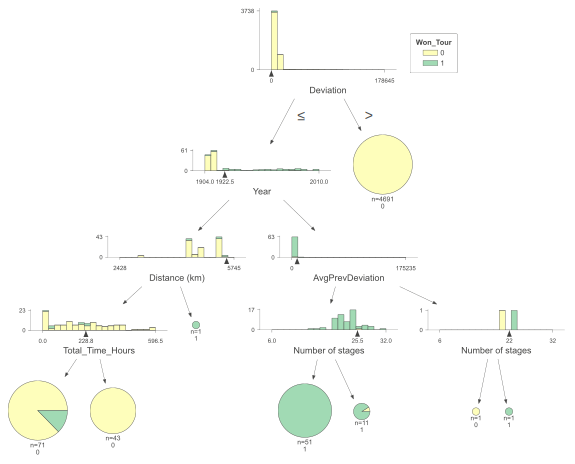

In [44]:
v = viz_model.view()
v

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


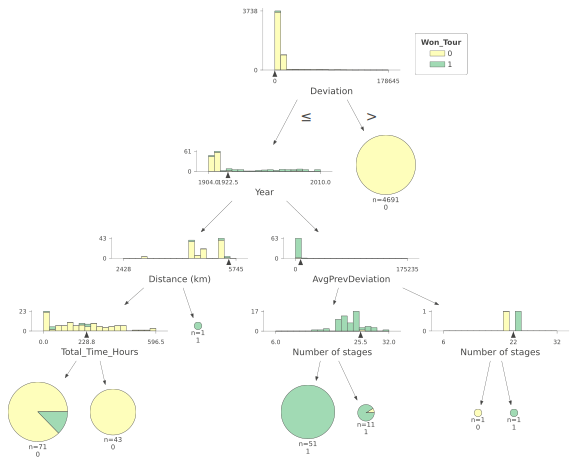

In [45]:
# Remove rows with NaN values in X_train and corresponding y_train_enc
X_train_clean = X_train.dropna()
y_train_clean = y_train_enc[X_train_clean.index]

viz_model = dtreeviz.model(
    tree_model,
    X_train=X_train_clean,
    y_train=y_train_clean,
    feature_names=list(X_train_clean.columns),
    target_name="Won_Tour",
    class_names=[str(c) for c in le.classes_]
)

v = viz_model.view(fontname="DejaVu Sans")
v

In [46]:

X_test.head()


,Year,Distance (km),Number of stages,Total_Time_Hours,Deviation,AvgPrevDeviation
29,2012,3497,21,90.004444,8729,11092.0
30,2013,3404,21,86.331944,8595,9910.5
31,2014,3659,21,92.890000,10458,9472.0
32,2015,3354,21,88.525556,13518,9718.5
33,2016,3525,21,92.653889,12866,10478.4


In [47]:
X_test




,Year,Distance (km),Number of stages,Total_Time_Hours,Deviation,AvgPrevDeviation
29,2012,3497,21,90.004444,8729,11092.000000
30,2013,3404,21,86.331944,8595,9910.500000
31,2014,3659,21,92.890000,10458,9472.000000
32,2015,3354,21,88.525556,13518,9718.500000
33,2016,3525,21,92.653889,12866,10478.400000
...,...,...,...,...,...,...
10156,2023,3404,21,86.805000,16956,13869.333333
10157,2024,3492,21,89.113056,19671,14641.000000
10173,2014,3659,21,94.736111,17104,NaN
10174,2015,3354,21,88.274167,12613,NaN


In [48]:
# Handle NaN values in X_test by filling with the mean from X_train
X_test_clean = X_test.fillna(X_train.mean())

y_pred_enc = tree_model.predict(X_test_clean)
y_pred = le.inverse_transform(y_pred_enc)
acc = accuracy_score(y_test, y_pred)
print(f"\nDecision Tree Accuracy on Test Set: {acc:.4f}")


Decision Tree Accuracy on Test Set: 1.0000


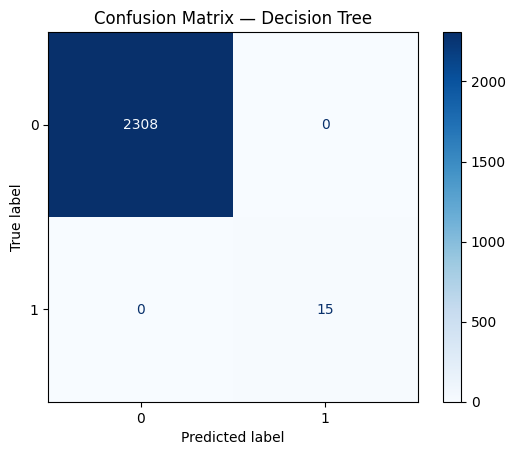

In [49]:
cm = confusion_matrix(y_test, y_pred, labels=le.classes_) # Create confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_) # Set class labels
disp.plot(cmap="Blues") # Set color map
plt.title("Confusion Matrix — Decision Tree") # Set title
plt.show() # Display plot

In [50]:
df2


,Rank,Rider,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),...,ResultType,TotalSeconds,GapSeconds,Won_Tour,Total_Time_Hours,Deviation,AvgPrevDeviation_team,Gap_Last_Race_Team,Rank_Last_Race_Team,Competition_Count_Team
0,24,JAANUSZ KUUM,204,A.D.R. - I.O.C.,85h 06' 46'',+ 00h 38' 53'',NaN,NaN,1988,3286,...,time,306406,2333,0,85.112778,2333,9219.80,NaN,NaN,1
1,102,FRANK DE WOLF,202,A.D.R. - I.O.C.,86h 23' 49'',+ 01h 55' 56'',NaN,NaN,1988,3286,...,time,311029,6956,0,86.396944,6956,10271.00,2333.0,24.0,2
2,115,EDDY PLANCKAERT,208,A.D.R. - I.O.C.,86h 37' 27'',+ 02h 09' 34'',NaN,NaN,1988,3286,...,time,311847,7774,0,86.624167,7774,11519.50,6956.0,102.0,3
3,124,FRANK HOSTE,203,A.D.R. - I.O.C.,86h 46' 43'',+ 02h 18' 50'',NaN,NaN,1988,3286,...,time,312403,8330,0,86.778611,8330,9442.25,7774.0,115.0,4
4,131,RENÉ MARTENS,205,A.D.R. - I.O.C.,86h 52' 45'',+ 02h 24' 52'',NaN,NaN,1988,3286,...,time,312765,8692,0,86.879167,8692,8072.00,8330.0,124.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10174,31,ANSELMO FUERTE,126,ZOR-BH,111h 47' 32'',+ 01h 12' 13'',NaN,NaN,1986,4094,...,time,402452,4333,0,111.792222,4333,1980.00,1980.0,8.0,2
10175,40,JÉSUS RODRIGUEZ-MAGRO,128,ZOR-BH,111h 55' 28'',+ 01h 20' 09'',NaN,NaN,1986,4094,...,time,402928,4809,0,111.924444,4809,5314.80,4333.0,31.0,3
10176,59,JUAN-CARLOS ROZAS,129,ZOR-BH,112h 17' 10'',+ 01h 41' 51'',NaN,NaN,1986,4094,...,time,404230,6111,0,112.286111,6111,5115.75,4809.0,40.0,4
10177,72,GUIDO VAN CALSTER,130,ZOR-BH,112h 26' 01'',+ 01h 50' 42'',NaN,NaN,1986,4094,...,time,404761,6642,0,112.433611,6642,4607.00,6111.0,59.0,5


Decision Tree (df2) Accuracy on Test Set: 1.0000
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2308
           1       1.00      1.00      1.00        15

    accuracy                           1.00      2323
   macro avg       1.00      1.00      1.00      2323
weighted avg       1.00      1.00      1.00      2323



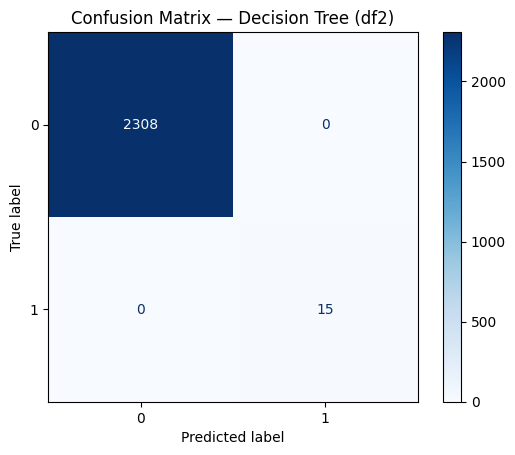

Top feature importances:
Year                                          0.661849
Deviation                                     0.247157
Competition_Count_Team                        0.061217
Gap_Last_Race_Team                            0.015734
Distance (km)                                 0.008190
Team_ALCYON                                   0.005853
Total_Time_Hours                              0.000000
TotalSeconds                                  0.000000
AvgPrevDeviation_team                         0.000000
Number of stages                              0.000000
B_33'                                         0.000000
Team_ACBB-SAINT RAPHAEL-HELYETT-HUTCHINSON    0.000000
Team_ADR-AGRIGEL-BOTTECCHIA                   0.000000
Team_AERNOUDT-HOONVED-ZEEP MARC               0.000000
Team_AFRIQUE DU NORD                          0.000000
Team_AG2R CITROEN TEAM                        0.000000
Team_AG2R LA MONDIALE                         0.000000
Team_AG2R PREVOYANCE                    

In [51]:
# Decision Tree classifier using df2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


df2 = df2.copy()
if 'Won_Tour' not in df2.columns:
    df2['Won_Tour'] = (df2.get('Rank') == 1).astype(int)

# Columns to drop if present
drop_cols = ['Rider No.', 'ResultType', 'Rider', 'Rank','GapSeconds', 'Gap', 'Times' ]

# Prepare features (dummy encode)
X2 = df2.drop(columns=[c for c in drop_cols if c in df2.columns] + ['Won_Tour'], errors='ignore')
y2 = df2['Won_Tour']
X2 = pd.get_dummies(X2, drop_first=True, dtype=float)

# Train/test split by Year (same scheme used earlier)
train_idx2 = df2['Year'] <= 2010
test_idx2 = (df2['Year'] >= 2011) & (df2['Year'] <= 2026)

X2_train = X2.loc[train_idx2].reindex(columns=X2.columns, fill_value=0)
y2_train = y2.loc[train_idx2]
X2_test = X2.loc[test_idx2].reindex(columns=X2.columns, fill_value=0)
y2_test = y2.loc[test_idx2]

# Fit the Decision Tree
tree2 = DecisionTreeClassifier(max_depth=4, random_state=123)
tree2.fit(X2_train.fillna(X2_train.mean()), y2_train)

# Predict and evaluate
y2_pred = tree2.predict(X2_test.fillna(X2_train.mean()))
acc2 = accuracy_score(y2_test, y2_pred)
print(f'Decision Tree (df2) Accuracy on Test Set: {acc2:.4f}')
print('Classification report:')
print(classification_report(y2_test, y2_pred))

# Confusion matrix
cm2 = confusion_matrix(y2_test, y2_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0,1])
disp2.plot(cmap='Blues')
plt.title('Confusion Matrix — Decision Tree (df2)')
plt.show()

# Feature importances (top 20)
importances = pd.Series(tree2.feature_importances_, index=X2_train.columns)
imp_top = importances.sort_values(ascending=False).head(20)
print('Top feature importances:')
print(imp_top)

Decision Tree (df2) Accuracy on Test Set: 1.0000
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2308
           1       1.00      1.00      1.00        15

    accuracy                           1.00      2323
   macro avg       1.00      1.00      1.00      2323
weighted avg       1.00      1.00      1.00      2323



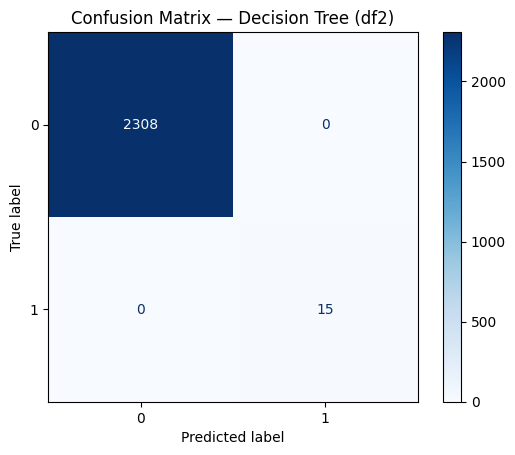

Top feature importances:
Year                                          0.661849
Deviation                                     0.247157
Competition_Count_Team                        0.061217
Gap_Last_Race_Team                            0.015734
Distance (km)                                 0.008190
Team_ALCYON                                   0.005853
Total_Time_Hours                              0.000000
TotalSeconds                                  0.000000
AvgPrevDeviation_team                         0.000000
Number of stages                              0.000000
B_33'                                         0.000000
Team_ACBB-SAINT RAPHAEL-HELYETT-HUTCHINSON    0.000000
Team_ADR-AGRIGEL-BOTTECCHIA                   0.000000
Team_AERNOUDT-HOONVED-ZEEP MARC               0.000000
Team_AFRIQUE DU NORD                          0.000000
Team_AG2R CITROEN TEAM                        0.000000
Team_AG2R LA MONDIALE                         0.000000
Team_AG2R PREVOYANCE                    

In [52]:
# Decision Tree classifier using df2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


df2 = df2.copy()
if 'Won_Tour' not in df2.columns:
    df2['Won_Tour'] = (df2.get('Rank') == 1).astype(int)

# Columns to drop if present
drop_cols = ['Rider No.', 'ResultType', 'Rider', 'Rank','GapSeconds', 'Gap', 'Times' ]

# Prepare features (dummy encode)
X2 = df2.drop(columns=[c for c in drop_cols if c in df2.columns] + ['Won_Tour'], errors='ignore')
y2 = df2['Won_Tour']
X2 = pd.get_dummies(X2, drop_first=True, dtype=float)

# Train/test split by Year (same scheme used earlier)
train_idx2 = df2['Year'] <= 2010
test_idx2 = (df2['Year'] >= 2011) & (df2['Year'] <= 2026)

X2_train = X2.loc[train_idx2].reindex(columns=X2.columns, fill_value=0)
y2_train = y2.loc[train_idx2]
X2_test = X2.loc[test_idx2].reindex(columns=X2.columns, fill_value=0)
y2_test = y2.loc[test_idx2]

# Fit the Decision Tree
tree2 = DecisionTreeClassifier(max_depth=4, random_state=123)
tree2.fit(X2_train.fillna(X2_train.mean()), y2_train)

# Predict and evaluate
y2_pred = tree2.predict(X2_test.fillna(X2_train.mean()))
acc2 = accuracy_score(y2_test, y2_pred)
print(f'Decision Tree (df2) Accuracy on Test Set: {acc2:.4f}')
print('Classification report:')
print(classification_report(y2_test, y2_pred))

# Confusion matrix
cm2 = confusion_matrix(y2_test, y2_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0,1])
disp2.plot(cmap='Blues')
plt.title('Confusion Matrix — Decision Tree (df2)')
plt.show()

# Feature importances (top 20)
importances = pd.Series(tree2.feature_importances_, index=X2_train.columns)
imp_top = importances.sort_values(ascending=False).head(20)
print('Top feature importances:')
print(imp_top)


Decision Tree (df2) - WITH DERIVED FEATURES
Accuracy on Test Set: 1.0000

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2308
           1       1.00      1.00      1.00        15

    accuracy                           1.00      2323
   macro avg       1.00      1.00      1.00      2323
weighted avg       1.00      1.00      1.00      2323



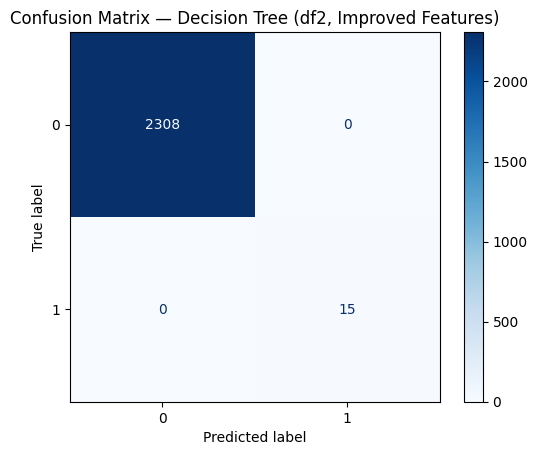


Top 15 feature importances:
Year                                          0.661849
Deviation                                     0.247157
Competition_Count_Team                        0.061217
Gap_Last_Race_Team                            0.015734
Distance (km)                                 0.008190
Team_ALCYON                                   0.005853
Total_Time_Hours                              0.000000
TotalSeconds                                  0.000000
AvgPrevDeviation_team                         0.000000
Number of stages                              0.000000
B_33'                                         0.000000
Team_ACBB-SAINT RAPHAEL-HELYETT-HUTCHINSON    0.000000
Team_ADR-AGRIGEL-BOTTECCHIA                   0.000000
Team_AERNOUDT-HOONVED-ZEEP MARC               0.000000
Team_AFRIQUE DU NORD                          0.000000
dtype: float64


In [53]:
# Decision Tree classifier using df2 WITH IMPROVED FEATURES (includes derived variables)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

df2_improved = df2.copy()
if 'Won_Tour' not in df2_improved.columns:
    df2_improved['Won_Tour'] = (df2_improved.get('Rank') == 1).astype(int)

# Columns to drop
drop_cols = ['Rider No.', 'ResultType', 'Rider', 'Rank','GapSeconds', 'Gap', 'Times']

# Prepare features with DERIVED VARIABLES
X2_imp = df2_improved.drop(columns=[c for c in drop_cols if c in df2_improved.columns] + ['Won_Tour'], errors='ignore')
y2_imp = df2_improved['Won_Tour']

# Dummy encode categorical variables
X2_imp = pd.get_dummies(X2_imp, drop_first=True, dtype=float)

# Train/test split by Year
train_idx2_imp = df2_improved['Year'] <= 2010
test_idx2_imp = (df2_improved['Year'] >= 2011) & (df2_improved['Year'] <= 2026)

X2_imp_train = X2_imp.loc[train_idx2_imp].reindex(columns=X2_imp.columns, fill_value=0)
y2_imp_train = y2_imp.loc[train_idx2_imp]
X2_imp_test = X2_imp.loc[test_idx2_imp].reindex(columns=X2_imp.columns, fill_value=0)
y2_imp_test = y2_imp.loc[test_idx2_imp]

# Fit the improved Decision Tree
tree2_imp = DecisionTreeClassifier(max_depth=4, random_state=123)
tree2_imp.fit(X2_imp_train.fillna(X2_imp_train.mean()), y2_imp_train)

# Predict and evaluate
y2_imp_pred = tree2_imp.predict(X2_imp_test.fillna(X2_imp_train.mean()))
acc2_imp = accuracy_score(y2_imp_test, y2_imp_pred)

print(f'\n{"="*60}')
print(f'Decision Tree (df2) - WITH DERIVED FEATURES')
print(f'{"="*60}')
print(f'Accuracy on Test Set: {acc2_imp:.4f}')
print(f'\nClassification report:')
print(classification_report(y2_imp_test, y2_imp_pred))

# Confusion matrix
cm2_imp = confusion_matrix(y2_imp_test, y2_imp_pred)
disp2_imp = ConfusionMatrixDisplay(confusion_matrix=cm2_imp, display_labels=[0, 1])
disp2_imp.plot(cmap='Blues')
plt.title('Confusion Matrix — Decision Tree (df2, Improved Features)')
plt.show()

# Feature importances (top 15)
importances_imp = pd.Series(tree2_imp.feature_importances_, index=X2_imp_train.columns)
imp_top_imp = importances_imp.sort_values(ascending=False).head(15)
print('\nTop 15 feature importances:')
print(imp_top_imp)


Detected leakage-related columns (will be removed): ['TotalSeconds', 'Total_Time_Hours', 'Deviation', 'AvgPrevDeviation_team', 'Rank_Last_Race_Team']
Using final feature set size: 695
Training positives: 90, negatives: 7766, scale_pos_weight=86.29

=== XGBoost (strict no-leakage) Results ===
Accuracy: 0.7680
ROC AUC:  0.8017
PR AUC:   0.0224

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      2308
           1       0.02      0.73      0.04        15

    accuracy                           0.77      2323
   macro avg       0.51      0.75      0.45      2323
weighted avg       0.99      0.77      0.86      2323



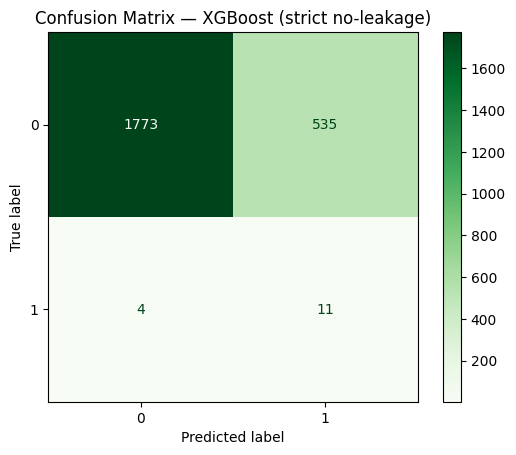

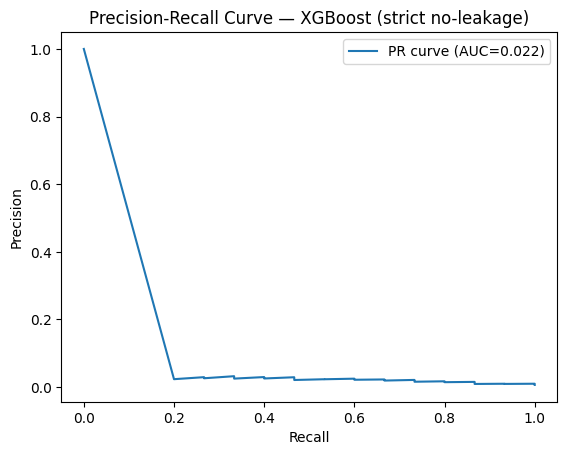


Top 15 feature importances (strict no-leakage):
Team_ALCYON                        0.068697
Gap_Last_Race_Team                 0.064441
Team_FRANCE                        0.051828
Team_PEUGEOT                       0.051693
Team_NEDERLAND                     0.049059
Team_MOLTENI                       0.045224
Team_RENAULT-GITANE                0.044641
Team_BANESTO                       0.044326
Team_OUEST                         0.042606
Competition_Count_Team             0.039271
Team_ALCYON-DUNLOP                 0.038983
Team_ITALIE                        0.036225
Team_PEUGEOT-BP                    0.029949
Team_LA VIE CLAIRE-WONDER-RADAR    0.028232
Team_CARRERA JEANS                 0.026754
dtype: float32

Previous Decision Tree accuracy (improved features): 1.0


In [54]:
# XGBoost classifier using df2 with derived variables — removing leaking columns and handling class imbalance
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, precision_recall_curve
)
import matplotlib.pyplot as plt

# Identify leakage keywords (these contain same-race outcomes) and remove any columns that match
leak_keywords = ['Rank', 'GapSeconds', 'TotalSeconds', 'Deviation', 'Total_Time_Hours', 'Times']
leak_present = [c for c in X2_imp_train.columns if any(k in c for k in leak_keywords)]
print('Detected leakage-related columns (will be removed):', leak_present)

# Build train/test feature matrices excluding leakage columns
X_xgb_train_raw = X2_imp_train.copy()
X_xgb_test_raw = X2_imp_test.copy()

X_xgb_train = X_xgb_train_raw.drop(columns=leak_present, errors='ignore').fillna(X_xgb_train_raw.mean())
X_xgb_test = X_xgb_test_raw.drop(columns=leak_present, errors='ignore').fillna(X_xgb_train_raw.mean())

# OPTIONALLY: limit to lag-derived features + team dummies to be strict
# We'll keep columns that either are derived lag features or are team dummies (start with 'Team_')
lag_features = [
    'Gap_Last_Race_Team', 'Rank_Last_Race_Team', 'Competition_Count_Team', 'AvgPrevDeviation_team'
]
team_dummies = [c for c in X_xgb_train.columns if c.startswith('Team_')]
# build final feature list as intersection to ensure we don't accidentally include leakage
final_features = [c for c in X_xgb_train.columns if (c in lag_features) or c in team_dummies]
print('Using final feature set size:', len(final_features))

# If final_features is empty (no team dummies), fall back to all non-leak columns
if len(final_features) == 0:
    final_features = X_xgb_train.columns.tolist()

X_xgb_train = X_xgb_train[final_features]
X_xgb_test = X_xgb_test.reindex(columns=final_features, fill_value=0)

# Ensure training indices are sorted by Year for any time-based splitting
train_order = df2_improved.loc[train_idx2_imp].sort_values('Year').index
X_xgb_train = X_xgb_train.loc[train_order].copy()
y_train_xgb = y2_imp_train.loc[train_order].copy()

# Handle class imbalance: compute scale_pos_weight = n_negative / n_positive
n_pos = (y_train_xgb == 1).sum()
n_neg = (y_train_xgb == 0).sum()
scale_pos = (n_neg / n_pos) if n_pos > 0 else 1.0
print(f"Training positives: {n_pos}, negatives: {n_neg}, scale_pos_weight={scale_pos:.2f}")

# Initialize and train XGBoost with class-weighting
xgb_model_clean = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=123,
    scale_pos_weight=scale_pos,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

xgb_model_clean.fit(X_xgb_train, y_train_xgb)

# Predictions and probabilities
X_xgb_test_ordered = X_xgb_test.reindex(index=X2_imp_test.index)
y_test_xgb = y2_imp_test.copy()

# Align test with final features 
X_xgb_test_ordered = X_xgb_test_ordered.fillna(X_xgb_train.mean())

y_pred_xgb = xgb_model_clean.predict(X_xgb_test_ordered)
y_prob_xgb = xgb_model_clean.predict_proba(X_xgb_test_ordered)[:, 1]

# Metrics
acc_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
# For ROC-AUC we need both classes present in test; guard against edge cases
try:
    roc_xgb = roc_auc_score(y_test_xgb, y_prob_xgb)
except ValueError:
    roc_xgb = float('nan')
pr_auc_xgb = average_precision_score(y_test_xgb, y_prob_xgb)

print('\n=== XGBoost (strict no-leakage) Results ===')
print(f'Accuracy: {acc_xgb:.4f}')
print(f'ROC AUC:  {roc_xgb:.4f}')
print(f'PR AUC:   {pr_auc_xgb:.4f}\n')
print('Classification report:')
print(classification_report(y_test_xgb, y_pred_xgb))

# Confusion matrix
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0,1])
disp_xgb.plot(cmap='Greens')
plt.title('Confusion Matrix — XGBoost (strict no-leakage)')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_xgb, y_prob_xgb)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc_xgb:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — XGBoost (strict no-leakage)')
plt.legend()
plt.show()

# Feature importances (top 15)
importances_xgb_clean = pd.Series(xgb_model_clean.feature_importances_, index=X_xgb_train.columns)
print('\nTop 15 feature importances (strict no-leakage):')
print(importances_xgb_clean.sort_values(ascending=False).head(15))

# Compare to previous improved tree accuracy 
try:
    print('\nPrevious Decision Tree accuracy (improved features):', acc2_imp)
except NameError:
    pass


In [55]:
# Inspect stage_data columns and sample rows to determine position column
print('stage_data columns:')
print(stage_data.columns.tolist())
print('\nstage_data sample:')
print(stage_data.head())


stage_data columns:
['Year', 'TotalTDFDistance', 'Stages', 'Start', 'End', 'Winner of stage', 'Yellow Jersey', 'Green jersey', 'Polka-dot jersey', 'White jersey', 'Leader']

stage_data sample:
   Year  TotalTDFDistance  Stages             Start               End  \
0  2025              3323     1.0   Lille Métropole   Lille Métropole   
1  2025              3323     2.0    Lauwin-Planque  Boulogne-sur-Mer   
2  2025              3323     3.0      Valenciennes         Dunkerque   
3  2025              3323     4.0  Amiens Métropole             Rouen   
4  2025              3323     5.0              Caen              Caen   

                              Winner of stage         Yellow Jersey  \
0      Jasper Philipsen  (Alpecin-Deceuninck)      Jasper Philipsen   
1  Mathieu Van Der Poel  (Alpecin-Deceuninck)  Mathieu Van Der Poel   
2            Tim Merlier  (Soudal Quick-Step)  Mathieu Van Der Poel   
3      Tadej Pogacar  (Uae Team Emirates Xrg)  Mathieu Van Der Poel   
4        Remc

Added rider prior-stage-wins and team prior-stage-wins (when available).
Detected leakage-related columns (will be removed): ['Rank', 'TotalSeconds', 'GapSeconds', 'Total_Time_Hours', 'Deviation', 'AvgPrevDeviation_team', 'Rank_Last_Race_Team', "Times_00h 00' 32''", "Times_00h 02' 16''", "Times_00h 04' 11''", "Times_00h 06' 09''", "Times_00h 07' 44''", "Times_00h 08' 40''", "Times_00h 11' 08''", "Times_00h 14' 10''", "Times_00h 16' 49''", "Times_00h 18' 22''", "Times_00h 18' 49''", "Times_00h 19' 00''", "Times_00h 20' 15''", "Times_00h 23' 12''", "Times_00h 25' 04''", "Times_00h 25' 28''", "Times_00h 27' 36''", "Times_00h 29' 41''", "Times_00h 31' 56''", "Times_00h 35' 43''", "Times_00h 37' 11''", "Times_00h 40' 26''", "Times_00h 41' 04''", "Times_00h 41' 35''", "Times_00h 42' 08''", "Times_00h 43' 03''", "Times_00h 43' 31''", "Times_00h 44' 50''", "Times_00h 45' 01''", "Times_00h 48' 04''", "Times_00h 49' 22''", "Times_00h 51' 05''", "Times_00h 54' 48''", "Times_00h 57' 02''", "Times_

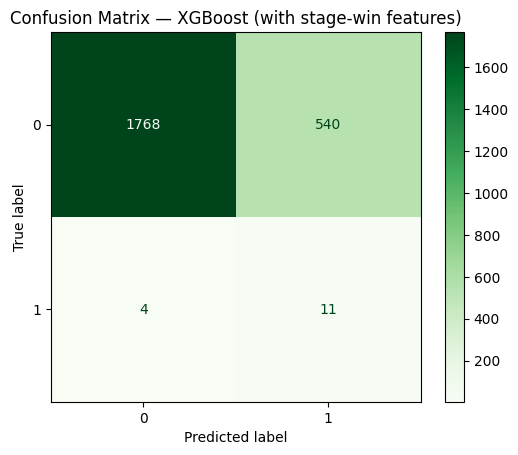

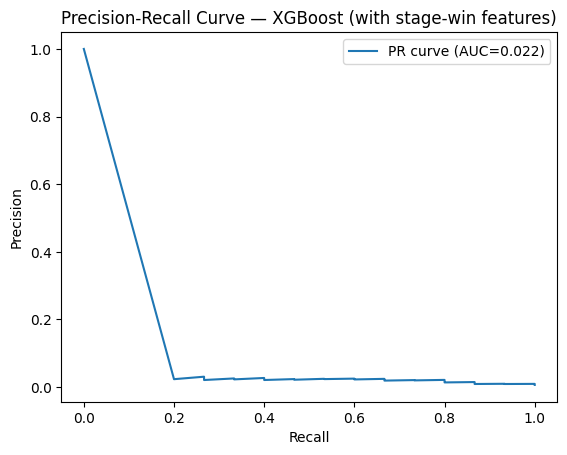


Top 15 feature importances (with stage-win features):
Gap_Last_Race_Team                 0.064501
Team_ALCYON                        0.061064
Team_PEUGEOT                       0.051067
Team_FRANCE                        0.048119
Team_NEDERLAND                     0.048020
Team_RENAULT-GITANE                0.042673
Team_MOLTENI                       0.042283
Team_BANESTO                       0.042023
Team_ALCYON-DUNLOP                 0.040422
Team_OUEST                         0.037672
Competition_Count_Team             0.037015
Team_ITALIE                        0.032809
Team_AUTOMOTO-HUTCHINSON           0.029282
Team_LA VIE CLAIRE-WONDER-RADAR    0.029173
Team_PEUGEOT-BP                    0.028972
dtype: float32


In [56]:
# Engineer rider-level stage-win features from `stage_data` (parse winners) and merge into df / df2,
# then retrain strict no-leakage XGBoost including these new features.

# Parse 'Winner of stage' to extract rider name and team (if present)
st = stage_data.copy()
if 'Winner of stage' in st.columns:
    def parse_winner(s):
        if pd.isna(s):
            return pd.Series({'stage_winner': None, 'stage_winner_team': None})
        # Example format: "Jasper Philipsen  (Alpecin-Deceuninck)"
        if '(' in s and ')' in s:
            name = s.split('(')[0].strip()
            team = s.split('(')[1].split(')')[0].strip()
        else:
            # fallback: take whole string as name
            name = s.strip()
            team = None
        return pd.Series({'stage_winner': name, 'stage_winner_team': team})

    parsed = st['Winner of stage'].apply(parse_winner)
    st = pd.concat([st, parsed], axis=1)
else:
    st['stage_winner'] = None
    st['stage_winner_team'] = None

# Aggregate stage wins per rider-year
wins = (
    st.dropna(subset=['stage_winner'])
      .groupby(['stage_winner', 'Year'])
      .size()
      .reset_index(name='stage_wins_in_year')
)

# Rename for merge
wins = wins.rename(columns={'stage_winner': 'Rider'})

# Compute cumulative previous stage wins per rider (up to previous year)
wins = wins.sort_values(['Rider', 'Year'])
wins['cum_stage_wins_prev'] = wins.groupby('Rider')['stage_wins_in_year'].cumsum().shift(1).fillna(0).astype(int)

# For riders with no entries in wins (never won a stage), ensure they get 0 when merged

# Merge rider-level prior stage wins into df
# df has Rider and Year
if 'Rider' in df.columns and 'Year' in df.columns:
    df = df.merge(wins[['Rider', 'Year', 'cum_stage_wins_prev']], on=['Rider', 'Year'], how='left')
    df['cum_stage_wins_prev'] = df['cum_stage_wins_prev'].fillna(0).astype(int)
else:
    print('Warning: df is missing Rider/Year columns; skipping rider-level merge')

# Now create team-level aggregation of prior stage wins by summing rider cum_stage_wins_prev per Team-Year
if 'Team' in df.columns and 'Year' in df.columns and 'cum_stage_wins_prev' in df.columns:
    team_agg = (
        df.groupby(['Team', 'Year'])['cum_stage_wins_prev']
          .sum()
          .reset_index(name='Team_Prior_Stage_Wins')
    )
    # Merge into df2 (team-level)
    if 'Team' in df2.columns and 'Year' in df2.columns:
        df2 = df2.merge(team_agg, on=['Team', 'Year'], how='left')
        df2['Team_Prior_Stage_Wins'] = df2['Team_Prior_Stage_Wins'].fillna(0).astype(int)
    else:
        print('Warning: df2 missing Team/Year; skipping team merge')
else:
    print('Warning: cannot compute team aggregates (missing columns)')

print('Added rider prior-stage-wins and team prior-stage-wins (when available).')

# Retrain strict no-leakage XGBoost using the same pipeline as before but including Team_Prior_Stage_Wins
# Rebuild X_xgb_train / X_xgb_test similar to previous cell but include the new feature when present

# Recreate X2_imp (dummy encoding) to include new columns if merged correctly
X2_imp = df2.copy().drop(columns=['Won_Tour'], errors='ignore')
X2_imp = pd.get_dummies(X2_imp, drop_first=True, dtype=float)

# train/test split
train_idx2_imp = df2['Year'] <= 2010
test_idx2_imp = (df2['Year'] >= 2011) & (df2['Year'] <= 2026)

X2_imp_train = X2_imp.loc[train_idx2_imp].reindex(columns=X2_imp.columns, fill_value=0)
X2_imp_test = X2_imp.loc[test_idx2_imp].reindex(columns=X2_imp.columns, fill_value=0)

y2_imp_train = df2.loc[train_idx2_imp, 'Won_Tour']
y2_imp_test = df2.loc[test_idx2_imp, 'Won_Tour']

# Remove leakage columns by keyword again
leak_keywords = ['Rank', 'GapSeconds', 'TotalSeconds', 'Deviation', 'Total_Time_Hours', 'Times']
leak_present = [c for c in X2_imp_train.columns if any(k in c for k in leak_keywords)]
print('Detected leakage-related columns (will be removed):', leak_present)

X_xgb_train = X2_imp_train.drop(columns=leak_present, errors='ignore').fillna(X2_imp_train.mean())
X_xgb_test = X2_imp_test.drop(columns=leak_present, errors='ignore').fillna(X2_imp_train.mean())

# Expand final features to include team prior stage wins if present
lag_features = [
    'Gap_Last_Race_Team', 'Rank_Last_Race_Team', 'Competition_Count_Team', 'AvgPrevDeviation_team'
]
# add the new team feature name if present
if 'Team_Prior_Stage_Wins' in X_xgb_train.columns:
    lag_features.append('Team_Prior_Stage_Wins')

team_dummies = [c for c in X_xgb_train.columns if c.startswith('Team_')]
final_features = [c for c in X_xgb_train.columns if (c in lag_features) or c in team_dummies]
if len(final_features) == 0:
    final_features = X_xgb_train.columns.tolist()

print('Final feature count (no leakage, with stage-wins):', len(final_features))

X_xgb_train = X_xgb_train[final_features]
X_xgb_test = X_xgb_test.reindex(columns=final_features, fill_value=0)

# sort training by Year
train_order = df2.loc[train_idx2_imp].sort_values('Year').index
X_xgb_train = X_xgb_train.loc[train_order].copy()
y_train_xgb = y2_imp_train.loc[train_order].copy()

# Retrain XGBoost with same hyperparams and evaluate
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, precision_recall_curve

n_pos = (y_train_xgb == 1).sum()
n_neg = (y_train_xgb == 0).sum()
scale_pos = (n_neg / n_pos) if n_pos > 0 else 1.0
print(f'Training positives: {n_pos}, negatives: {n_neg}, scale_pos_weight={scale_pos:.2f}')

xgb_model_new = xgb.XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=123, scale_pos_weight=scale_pos, use_label_encoder=False, eval_metric='logloss', verbosity=0)

xgb_model_new.fit(X_xgb_train, y_train_xgb)

X_xgb_test_ordered = X_xgb_test.reindex(index=X2_imp_test.index)
y_test_xgb = y2_imp_test.copy()

X_xgb_test_ordered = X_xgb_test_ordered.fillna(X_xgb_train.mean())

y_pred_new = xgb_model_new.predict(X_xgb_test_ordered)
y_prob_new = xgb_model_new.predict_proba(X_xgb_test_ordered)[:, 1]

acc_new = accuracy_score(y_test_xgb, y_pred_new)
try:
    roc_new = roc_auc_score(y_test_xgb, y_prob_new)
except ValueError:
    roc_new = float('nan')
pr_auc_new = average_precision_score(y_test_xgb, y_prob_new)

print('\n=== XGBoost (with rider stage-win features) Results ===')
print(f'Accuracy: {acc_new:.4f}')
print(f'ROC AUC:  {roc_new:.4f}')
print(f'PR AUC:   {pr_auc_new:.4f}\n')
print('Classification report:')
print(classification_report(y_test_xgb, y_pred_new))

cm_new = confusion_matrix(y_test_xgb, y_pred_new)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=[0,1])
disp_new.plot(cmap='Greens')
import matplotlib.pyplot as plt
plt.title('Confusion Matrix — XGBoost (with stage-win features)')
plt.show()

precision, recall, _ = precision_recall_curve(y_test_xgb, y_prob_new)
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc_new:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — XGBoost (with stage-win features)')
plt.legend()
plt.show()

importances_new = pd.Series(xgb_model_new.feature_importances_, index=X_xgb_train.columns)
print('\nTop 15 feature importances (with stage-win features):')
print(importances_new.sort_values(ascending=False).head(15))


Best threshold (max F1): 0.7687 with F1=0.0552

Threshold evaluation:
t=0.500  precision=0.020  recall=0.733  f1=0.039  TP=11  FP=540  FN=4  TN=1768
t=0.750  precision=0.025  recall=0.267  f1=0.046  TP=4  FP=155  FN=11  TN=2153
t=0.769  precision=0.027  recall=0.267  f1=0.049  TP=4  FP=143  FN=11  TN=2165
t=0.900  precision=0.000  recall=0.000  f1=0.000  TP=0  FP=0  FN=15  TN=2308
Precision@5: 0.200 (positives in top 5 = 1)
Precision@10: 0.100 (positives in top 10 = 1)
Precision@15: 0.067 (positives in top 15 = 1)
Precision@20: 0.050 (positives in top 20 = 1)
Precision@50: 0.040 (positives in top 50 = 2)


/var/folders/vy/pldbp8tx5bzcr752wcc7m57h0000gn/T/ipykernel_69408/1987889581.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.


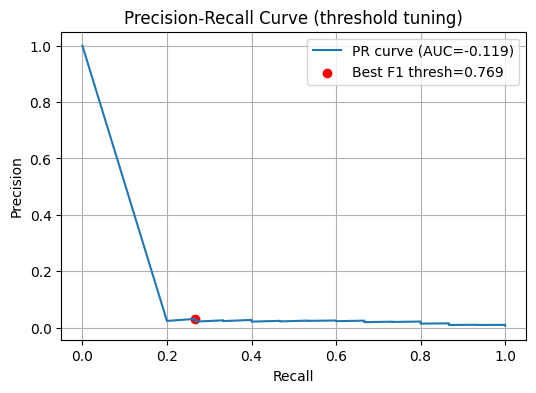

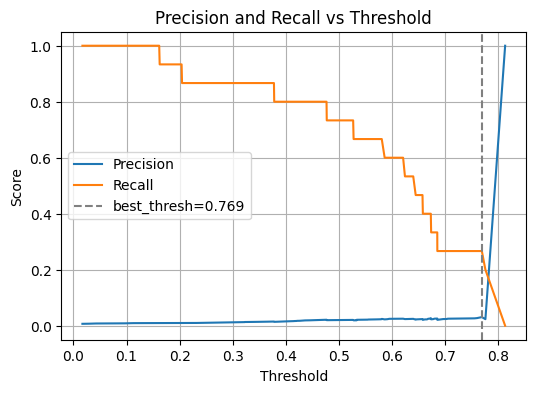

In [57]:
# Threshold tuning for XGBoost predictions
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np

# Prefer the most recent variables (y_prob_new / y_test_xgb). Fall back to alternatives if needed.
try:
    y_true = y_test_xgb
    y_prob = y_prob_new
except NameError:
    try:
        y_true = y_test_xgb
        y_prob = y_prob_xgb
    except NameError:
        raise NameError('Could not find prediction variables (y_test_xgb / y_prob_new). Run the model cells first.')

precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
# precision_recall_curve returns precision and recall for thresholds between points; align lengths
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
# thresholds array corresponds to precision[1:], recall[1:]; align f1 accordingly
f1_for_thresholds = f1_scores[1:]

if len(thresholds) > 0:
    best_idx = np.nanargmax(f1_for_thresholds)
    best_thresh = thresholds[best_idx]
    best_f1 = f1_for_thresholds[best_idx]
else:
    best_thresh = 0.5
    best_f1 = f1_score(y_true, (y_prob >= best_thresh).astype(int))

print(f'Best threshold (max F1): {best_thresh:.4f} with F1={best_f1:.4f}')

# Evaluate at several thresholds including the best and common choices
candidate_thresholds = [0.5, best_thresh, 0.75, 0.9]
candidate_thresholds = sorted(set([t for t in candidate_thresholds if t >= 0 and t <= 1]))

results = []
for t in candidate_thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    p = precision_score(y_true, y_pred_t, zero_division=0)
    r = recall_score(y_true, y_pred_t, zero_division=0)
    f1 = f1_score(y_true, y_pred_t, zero_division=0)
    cm = confusion_matrix(y_true, y_pred_t)
    results.append({'threshold': t, 'precision': p, 'recall': r, 'f1': f1, 'cm': cm})

print('\nThreshold evaluation:')
for r in results:
    tn, fp, fn, tp = r['cm'].ravel()
    print(f"t={r['threshold']:.3f}  precision={r['precision']:.3f}  recall={r['recall']:.3f}  f1={r['f1']:.3f}  TP={tp}  FP={fp}  FN={fn}  TN={tn}")

# Precision@k (top-k by probability) - useful for rare events; show for k=10,15,20
ks = [5, 10, 15, 20, 50]
sorted_idx = np.argsort(-y_prob)
for k in ks:
    if k <= len(y_prob):
        topk_idx = sorted_idx[:k]
        topk_prec = y_true.iloc[topk_idx].sum() / k
        print(f'Precision@{k}: {topk_prec:.3f} (positives in top {k} = {int(y_true.iloc[topk_idx].sum())})')

# Plot PR curve and mark best threshold
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'PR curve (AUC={np.nan_to_num(np.trapz(precision, recall)):.3f})')
# find recall/precision at best_thresh
if len(thresholds) > 0:
    # find nearest index where threshold >= best_thresh
    idx = (np.abs(thresholds - best_thresh)).argmin()
    rp = (recall[idx+1], precision[idx+1])
    plt.scatter([rp[0]], [rp[1]], color='red', label=f'Best F1 thresh={best_thresh:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (threshold tuning)')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision and recall vs threshold
plt.figure(figsize=(6,4))
plt.plot(thresholds, precision[1:], label='Precision')
plt.plot(thresholds, recall[1:], label='Recall')
plt.axvline(best_thresh, color='grey', linestyle='--', label=f'best_thresh={best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


Rider model test accuracy: 1.0

Team model test accuracy: 0.963855421686747

Using candidate roster source: carried_forward_from_2025; candidates: 160
Saved combined predictions to: /Users/connortoomey/Desktop/Mod2 Machine Learning/predicted_2026_combined.csv


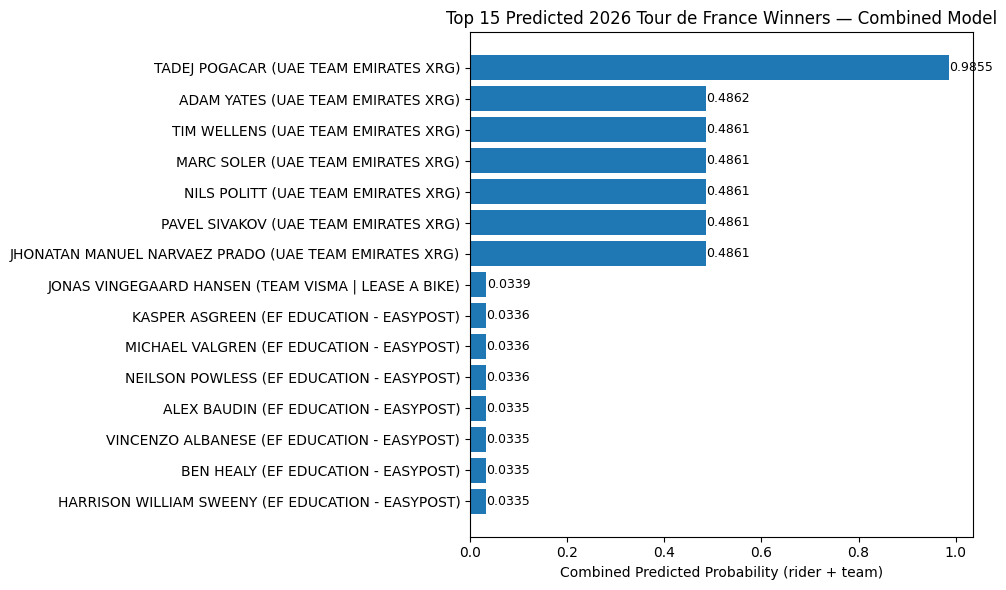


Top predicted 2026 winner: TADEJ POGACAR (UAE TEAM EMIRATES XRG) — combined prob 0.9855


In [58]:
# Predict 2026 using both rider-level (`df`) and team-level (`df2`) models
# - If Year==2026 rows exist we use them; otherwise we carry-forward the most recent roster as 2026 candidates.
# - Train strict no-leakage XGBoosts for rider and team, predict probabilities, average them per rider, plot top-15, save CSV.

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, average_precision_score

# Ensure df and df2 exist (recompute if needed)
try:
    df
except NameError:
    df = rider_data.sort_values(["Rider", "Year"]).reset_index(drop=True)

try:
    df2
except NameError:
    df2 = rider_data.sort_values(["Team", "Year"]).reset_index(drop=True)

# Recreate derived rider/team features (lag-based)
df = df.sort_values(["Rider", "Year"]).reset_index(drop=True)
df['Won_Tour'] = (df['Rank'] == 1).astype(int)
df['Gap_Last_Race'] = df.groupby('Rider')['GapSeconds'].shift(1)
df['Rank_Last_Race'] = df.groupby('Rider')['Rank'].shift(1)
df['Competition_Count'] = df.groupby('Rider').cumcount() + 1

# merge stage wins if present (from earlier 'cum_stage_wins_prev' column in df)
if 'cum_stage_wins_prev' not in df.columns and 'cum_stage_wins_prev' in globals().get('df', pd.DataFrame()).columns:
    pass

# Team features
# compute team-level derived features if not present
if 'Gap_Last_Race_Team' not in df2.columns:
    df2['Won_Tour'] = (df2.get('Rank') == 1).astype(int)
    df2['Gap_Last_Race_Team'] = df2.groupby('Team')['GapSeconds'].shift(1)
    df2['Rank_Last_Race_Team'] = df2.groupby('Team')['Rank'].shift(1)
    df2['Competition_Count_Team'] = df2.groupby('Team').cumcount() + 1

# Aggregate team->team-year rows for team model
team_agg = (
    df2.groupby(['Team', 'Year'])
       .agg({
           'Won_Tour': 'max',
           'Gap_Last_Race_Team': 'first',
           'Rank_Last_Race_Team': 'first',
           'Competition_Count_Team': 'first',
           'AvgPrevDeviation_team': 'first',
           'Team_Prior_Stage_Wins': 'first'
       })
       .reset_index()
)
team_agg['Won_Tour'] = team_agg['Won_Tour'].fillna(0).astype(int)

# Build rider-level feature matrix (no leakage)
def build_rider_X(df_in):
    X = df_in.copy()
    drop_cols = ['Rider No.', 'ResultType', 'Rider']
    leak_keywords = ['Rank', 'GapSeconds', 'TotalSeconds', 'Deviation', 'Total_Time_Hours', 'Times']
    X = X.drop(columns=[c for c in drop_cols if c in X.columns] + ['Won_Tour'], errors='ignore')
    leak_cols = [c for c in X.columns if any(k in c for k in leak_keywords)]
    X = X.drop(columns=leak_cols, errors='ignore')
    X = pd.get_dummies(X, drop_first=True, dtype=float)
    return X

X_rider = build_rider_X(df)

y_rider = df['Won_Tour']

# train/test split by Year
train_idx = df['Year'] <= 2010
test_idx = (df['Year'] >= 2011) & (df['Year'] <= 2026)

Xr_train = X_rider.loc[train_idx].fillna(X_rider.loc[train_idx].mean())
yr_train = y_rider.loc[train_idx]

Xr_test = X_rider.loc[test_idx].reindex(columns=Xr_train.columns, fill_value=0).fillna(Xr_train.mean())
yr_test = y_rider.loc[test_idx]

# Fit rider XGBoost
n_pos = (yr_train == 1).sum()
n_neg = (yr_train == 0).sum()
scale_pos = (n_neg / n_pos) if n_pos > 0 else 1.0
rider_model = xgb.XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=123, scale_pos_weight=scale_pos, use_label_encoder=False, eval_metric='logloss', verbosity=0)
rider_model.fit(Xr_train, yr_train)

# Evaluate rider model on test slice
try:
    yr_pred = rider_model.predict(Xr_test)
    print('\nRider model test accuracy:', accuracy_score(yr_test, yr_pred))
except Exception:
    pass

# Build team-level feature matrix
team_feat_cols = ['Gap_Last_Race_Team', 'Rank_Last_Race_Team', 'Competition_Count_Team', 'AvgPrevDeviation_team', 'Team_Prior_Stage_Wins']
team_X = team_agg.copy()
# keep only team features
team_X_matrix = team_X[['Team', 'Year'] + [c for c in team_feat_cols if c in team_X.columns]].copy()
team_X_matrix = pd.get_dummies(team_X_matrix, columns=['Team'], drop_first=True, dtype=float)

# target
y_team = team_agg['Won_Tour']

# train/test for team
train_idx_team = team_agg['Year'] <= 2010
test_idx_team = (team_agg['Year'] >= 2011) & (team_agg['Year'] <= 2026)

Xt_train = team_X_matrix.loc[train_idx_team].reindex(columns=team_X_matrix.columns, fill_value=0).fillna(0)
yt_train = y_team.loc[train_idx_team]

Xt_test = team_X_matrix.loc[test_idx_team].reindex(columns=team_X_matrix.columns, fill_value=0).fillna(0)
yt_test = y_team.loc[test_idx_team]

# Fit team model (guard if no positive teams)
n_pos_t = (yt_train == 1).sum()
n_neg_t = (yt_train == 0).sum()
scale_pos_t = (n_neg_t / n_pos_t) if n_pos_t > 0 else 1.0
team_model = xgb.XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=123, scale_pos_weight=scale_pos_t, use_label_encoder=False, eval_metric='logloss', verbosity=0)
team_model.fit(Xt_train, yt_train)

# Evaluate team model
try:
    yt_pred = team_model.predict(Xt_test)
    print('\nTeam model test accuracy:', accuracy_score(yt_test, yt_pred))
except Exception:
    pass

# Build 2026 candidate roster
target_year = 2026
if (df['Year'] == target_year).sum() > 0:
    candidates = df[df['Year'] == target_year].copy()
    source_note = 'exact_2026_rows'
else:
    # carry-forward most recent roster
    max_year = df['Year'].max()
    candidates = df[df['Year'] == max_year].copy()
    candidates['Year'] = target_year
    source_note = f'carried_forward_from_{max_year}'

print(f"\nUsing candidate roster source: {source_note}; candidates: {len(candidates)}")

# Rider-level predictions for candidates
X_cand_rider = build_rider_X(candidates)
X_cand_rider = X_cand_rider.reindex(columns=Xr_train.columns, fill_value=0).fillna(Xr_train.mean())
prob_rider = rider_model.predict_proba(X_cand_rider)[:, 1]

# Team-level predictions for candidate teams: construct team-year rows for target_year
team_candidates = team_agg[team_agg['Year'] == target_year].copy()
if len(team_candidates) == 0:
    # carry-forward team_agg from most recent
    team_candidates = team_agg[team_agg['Year'] == team_agg['Year'].max()].copy()
    team_candidates['Year'] = target_year

Xt_cand = team_candidates.copy()
Xt_cand_matrix = Xt_cand[['Team', 'Year'] + [c for c in team_feat_cols if c in Xt_cand.columns]]
Xt_cand_matrix = pd.get_dummies(Xt_cand_matrix, columns=['Team'], drop_first=True, dtype=float)
# reindex to team model columns
Xt_cand_matrix = Xt_cand_matrix.reindex(columns=team_X_matrix.columns, fill_value=0).fillna(0)
prob_team = team_model.predict_proba(Xt_cand_matrix)[:, 1]
team_candidates = team_candidates.reset_index(drop=True)
team_candidates['Team_Prob'] = prob_team

# Map team probs to riders
cand_df = candidates.reset_index(drop=True).copy()
# ensure team names align
cand_df = cand_df.merge(team_candidates[['Team', 'Team_Prob']], on='Team', how='left')
# if some teams missing, fill with small value
cand_df['Team_Prob'] = cand_df['Team_Prob'].fillna(cand_df['Team_Prob'].median() if not np.isnan(cand_df['Team_Prob'].median()) else 0.0)

cand_df['Rider_Prob'] = prob_rider
# combined score = average (you can change weighting)
cand_df['Combined_Prob'] = (cand_df['Rider_Prob'] + cand_df['Team_Prob']) / 2.0

results_2026 = cand_df[['Rider', 'Team', 'Year', 'Rider_Prob', 'Team_Prob', 'Combined_Prob']].sort_values('Combined_Prob', ascending=False).reset_index(drop=True)

# Save CSV
out_path = '/Users/connortoomey/Desktop/Mod2 Machine Learning/predicted_2026_combined.csv'
results_2026.to_csv(out_path, index=False)
print(f"Saved combined predictions to: {out_path}")

# Plot top 15
top_n = min(15, len(results_2026))
top = results_2026.head(top_n).copy()
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top['Combined_Prob'], color='tab:blue')
plt.yticks(range(top_n), [f"{r} ({t})" for r, t in zip(top['Rider'], top['Team'])])
plt.gca().invert_yaxis()
plt.xlabel('Combined Predicted Probability (rider + team)')
plt.title(f'Top {top_n} Predicted {target_year} Tour de France Winners — Combined Model')
for i, val in enumerate(top['Combined_Prob']):
    plt.text(val + 0.0005, i, f"{val:.4f}", va='center', fontsize=9)
plt.tight_layout()
plt.show()

print(f"\nTop predicted {target_year} winner: {results_2026.iloc[0]['Rider']} ({results_2026.iloc[0]['Team']}) — combined prob {results_2026.iloc[0]['Combined_Prob']:.4f}")



